In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import seaborn as sns
import yfinance as yf
sns.set()

In [3]:
tickers=['^NSEBANK','^NSEI']
data = pd.DataFrame()
for ticker in tickers:
    data[ticker]=yf.download(ticker,start='2010-01-01',end='2025-7-7')['Close']

C:\Users\swana\AppData\Local\Temp\ipykernel_3900\690378777.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data[ticker]=yf.download(ticker,start='2010-01-01',end='2025-7-7')['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\swana\AppData\Local\Temp\ipykernel_3900\690378777.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data[ticker]=yf.download(ticker,start='2010-01-01',end='2025-7-7')['Close']
[*********************100%***********************]  1 of 1 completed


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3532 entries, 2010-01-04 to 2025-07-04
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ^NSEBANK  3532 non-null   float64
 1   ^NSEI     3530 non-null   float64
dtypes: float64(2)
memory usage: 82.8 KB


In [5]:
data.head()

,^NSEBANK,^NSEI
Date,,
2010-01-04,9112.244141,5232.200195
2010-01-05,9192.043945,5277.899902
2010-01-06,9222.892578,5281.799805
2010-01-07,9192.843750,5263.100098
2010-01-08,9160.593750,5244.750000


In [6]:
data.isna().sum()

^NSEBANK    0
^NSEI       2
dtype: int64

In [7]:
## Dropping Null Values
data.dropna(inplace=True)

In [8]:
data.isna().sum()

^NSEBANK    0
^NSEI       0
dtype: int64

In [9]:
df=data.copy()

In [10]:
df.head()

,^NSEBANK,^NSEI
Date,,
2010-01-04,9112.244141,5232.200195
2010-01-05,9192.043945,5277.899902
2010-01-06,9222.892578,5281.799805
2010-01-07,9192.843750,5263.100098
2010-01-08,9160.593750,5244.750000


In [11]:
df=df.asfreq('B')

In [12]:
df.head()

,^NSEBANK,^NSEI
Date,,
2010-01-04,9112.244141,5232.200195
2010-01-05,9192.043945,5277.899902
2010-01-06,9222.892578,5281.799805
2010-01-07,9192.843750,5263.100098
2010-01-08,9160.593750,5244.750000


In [13]:
df.isna().sum()

^NSEBANK    515
^NSEI       515
dtype: int64

In [14]:
df.fillna(method='ffill',inplace=True)

C:\Users\swana\AppData\Local\Temp\ipykernel_3900\4116506308.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill',inplace=True)


In [15]:
df.isna().sum()

^NSEBANK    0
^NSEI       0
dtype: int64

In [16]:
## Simplyfying the Datasets
df['Market_value']=df['^NSEBANK']

In [17]:
df.head()

,^NSEBANK,^NSEI,Market_value
Date,,,
2010-01-04,9112.244141,5232.200195,9112.244141
2010-01-05,9192.043945,5277.899902,9192.043945
2010-01-06,9222.892578,5281.799805,9222.892578
2010-01-07,9192.843750,5263.100098,9192.843750
2010-01-08,9160.593750,5244.750000,9160.593750


In [18]:
## Deleting Extra Columns 
del df['^NSEBANK'],df['^NSEI']

In [19]:
df.head()

,Market_value
Date,
2010-01-04,9112.244141
2010-01-05,9192.043945
2010-01-06,9222.892578
2010-01-07,9192.843750
2010-01-08,9160.593750


In [20]:
df.describe()

,Market_value
count,4045.000000
mean,25076.327577
std,13321.497160
min,7798.458984
25%,12424.555664
50%,22264.642578
75%,35123.988281
max,57459.449219


In [21]:
## Spliting the Date
size=int(len(df)*0.8)
train=df.iloc[:size]
test=df.iloc[size:]

In [22]:
train.tail()

,Market_value
Date,
2022-05-24,34289.750000
2022-05-25,34339.101562
2022-05-26,35094.492188
2022-05-27,35612.886719
2022-05-30,35826.531250


In [23]:
test.head()

,Market_value
Date,
2022-05-31,35486.984375
2022-06-01,35620.386719
2022-06-02,35613.234375
2022-06-03,35274.640625
2022-06-06,35309.789062


## ploting ACF anf PACF plots

Text(0.5, 1.0, 'ACF Bank Nifty')

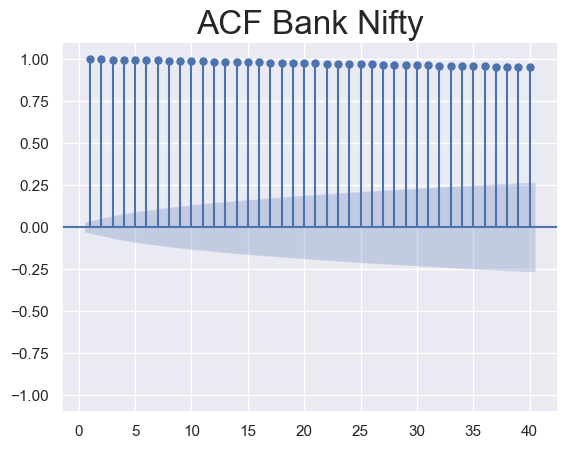

In [24]:
## ACF
sgt.plot_acf(df.Market_value,lags=40,zero=False)
plt.ylim(-1.1,1.1)
plt.title("ACF Bank Nifty",size=24)

Text(0.5, 1.0, 'PACF Bank Nifty')

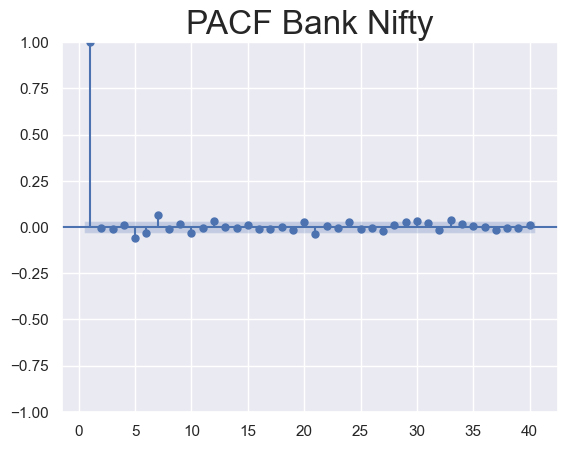

In [25]:
## Pacf 
sgt.plot_pacf(df.Market_value,lags=40,zero=False,method=('ols'))
plt.title("PACF Bank Nifty",size=24)

In [26]:
## Defining LLR Test for Easy Comparison
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Multiple AR models for many Lags and comparing them (for Prices)


In [27]:
model_ar1 = ARIMA(df.Market_value, order=(1,0,0))
result_ar1=model_ar1.fit()
result_ar1.summary()

e:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Market_value   No. Observations:                 4045
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -29346.741
Date:                Sun, 07 Sep 2025   AIC                          58699.482
Time:                        14:24:45   BIC                          58718.398
Sample:                    01-04-2010   HQIC                         58706.183
                         - 07-04-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.508e+04      1.137   2.21e+04      0.000    2.51e+04    2.51e+04
ar.L1          0.9998      0.000   2762.270      0.000       0.999       1.000
sigma2      1.173e+05    924.670    126.833      0.000    1.15e+05    1.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):             35090.65
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               6.99   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.56e+18. Standard errors may be unstable.
"""

In [28]:
model_ar2 = ARIMA(df.Market_value, order=(2,0,0))
result_ar2=model_ar2.fit()
result_ar2.summary()

e:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Market_value   No. Observations:                 4045
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -29346.499
Date:                Sun, 07 Sep 2025   AIC                          58700.997
Time:                        14:24:46   BIC                          58726.218
Sample:                    01-04-2010   HQIC                         58709.932
                         - 07-04-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.508e+04      0.519   4.84e+04      0.000    2.51e+04    2.51e+04
ar.L1          1.0093      0.008    131.802      0.000       0.994       1.024
ar.L2         -0.0094      0.008     -1.235      0.217      -0.024       0.006
sigma2       1.17e+05    976.446    119.795      0.000    1.15e+05    1.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             35680.81
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               7.00   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.53e+18. Standard errors may be unstable.
"""

In [29]:
model_ar3 = ARIMA(df.Market_value, order=(3,0,0))
result_ar3=model_ar3.fit()
result_ar3.summary()

e:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Market_value   No. Observations:                 4045
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -29346.175
Date:                Sun, 07 Sep 2025   AIC                          58702.350
Time:                        14:24:49   BIC                          58733.876
Sample:                    01-04-2010   HQIC                         58713.519
                         - 07-04-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.508e+04      0.506   4.95e+04      0.000    2.51e+04    2.51e+04
ar.L1          1.0092      0.008    129.954      0.000       0.994       1.024
ar.L2          0.0021      0.011      0.189      0.850      -0.020       0.024
ar.L3         -0.0114      0.009     -1.227      0.220      -0.030       0.007
sigma2       1.17e+05    974.710    120.033      0.000    1.15e+05    1.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             35635.43
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               7.00   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.73e+18. Standard errors may be unstable.
"""

We stopped here only because p>z value is way more than our significance value so we will use ar1 model I  didnt stopped on ar2 model because I wanted to see can next model will be better than the previous one

## Performing LLR Test on All three model

In [30]:
LLR_test(model_ar1,model_ar2)

e:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
e:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


np.float64(0.486)

In [31]:
LLR_test(model_ar2,model_ar3)

e:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
e:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


np.float64(0.421)

As this both values are more than our significance value of 5% so we will use ar1 model

## Analysing the residuals

In [32]:
df['res_price']=result_ar1.resid

In [33]:
## Residual Mean
df.res_price.mean()

np.float64(7.898344382239234)

In [34]:
## Residual Variance
df.res_price.var()

180006.9917221044

In [35]:
## Dicky Fuller Test
sts.adfuller(df.res_price)

(np.float64(-25.856300904513553),
 0.0,
 5,
 4039,
 {'1%': np.float64(-3.4319700695341306),
  '5%': np.float64(-2.862255858067265),
  '10%': np.float64(-2.567151058546466)},
 np.float64(58217.953936039354))

Text(0.5, 1.0, 'ACF of Residuals FOR Price')

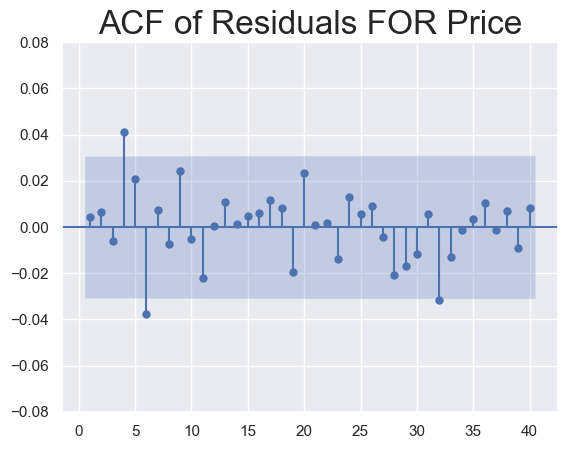

In [37]:
## Ploting ACF for Residuals
sgt.plot_acf(df.res_price,lags=40,zero=False)
plt.ylim(-0.08,0.08)
plt.title("ACF of Residuals FOR Price",size=24)

Text(0.5, 1.0, 'PACF of Residuals FOR Price')

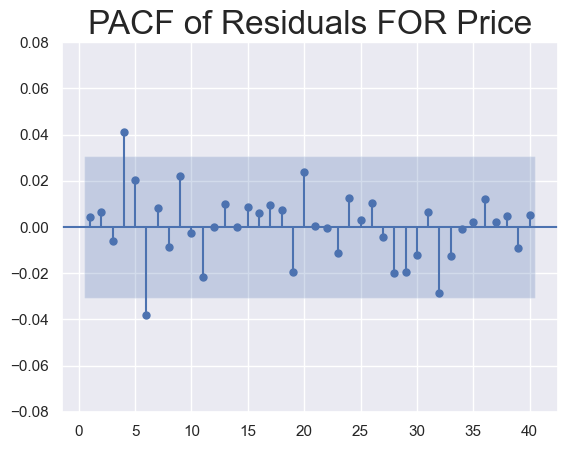

In [39]:
## Ploting PACF for Residuals
sgt.plot_pacf(df.res_price,lags=40,zero=False)
plt.ylim(-0.08,0.08)
plt.title("PACF of Residuals FOR Price",size=24)

## Now calculating The same Things for returns

In [42]:
## Adding Returns to the dataframe
df['returns']=df.Market_value.pct_change(1)*100
df=df.iloc[1:]
df.head()

C:\Users\swana\AppData\Local\Temp\ipykernel_3900\4159919054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns']=df.Market_value.pct_change(1)*100


,Market_value,res_price,returns
Date,,,
2010-01-06,9222.892578,27.508321,0.335601
2010-01-07,9192.843750,-33.382652,-0.325807
2010-01-08,9160.593750,-35.590143,-0.350816
2010-01-11,9173.443359,9.502684,0.140270
2010-01-12,8984.995117,-191.792465,-2.054280


In [43]:
## Running Dicky Fuller test for Returns
sts.adfuller(df.returns)

(np.float64(-18.80624308728291),
 np.float64(2.0226197635110018e-30),
 10,
 4032,
 {'1%': np.float64(-3.4319728839485406),
  '5%': np.float64(-2.8622571013298965),
  '10%': np.float64(-2.5671517204059)},
 np.float64(14295.150885383808))

## Ploting PACF and ACF for Returns

(-0.1, 0.1)

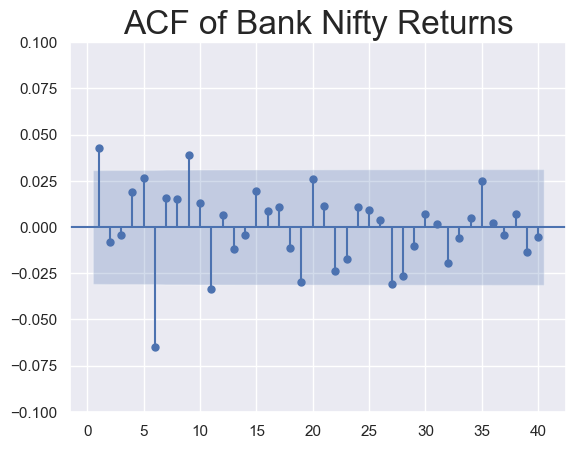

In [44]:
sgt.plot_acf(df.returns,lags=40,zero=False)
plt.title("ACF of Bank Nifty Returns",size=24)
plt.ylim(-0.1,0.1)

(-0.1, 0.1)

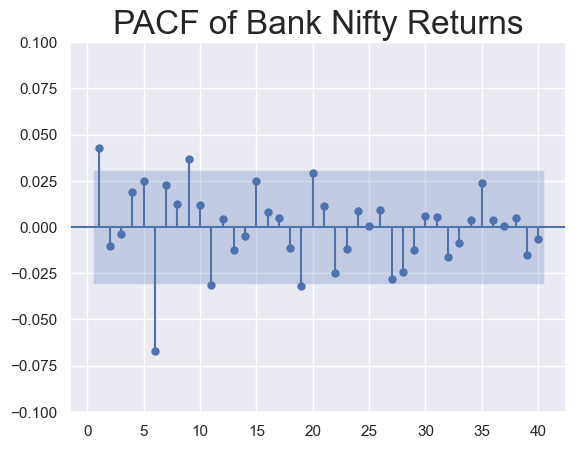

In [45]:
sgt.plot_pacf(df.returns,lags=40,zero=False)
plt.title("PACF of Bank Nifty Returns",size=24)
plt.ylim(-0.1,0.1)

## AR Models for Returns

In [46]:
model_ret_ar1=ARIMA(df.returns, order=(1,0,0))
results_ret_ar1 = model_ret_ar1.fit()
results_ret_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 4043
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7213.324
Date:                Sun, 07 Sep 2025   AIC                          14432.649
Time:                        14:32:15   BIC                          14451.563
Sample:                    01-06-2010   HQIC                         14439.350
                         - 07-04-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0555      0.024      2.343      0.019       0.009       0.102
ar.L1          0.0429      0.011      3.775      0.000       0.021       0.065
sigma2         2.0759      0.015    140.566      0.000       2.047       2.105
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             52613.53
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
model_ret_ar2=ARIMA(df.returns, order=(2,0,0))
results_ret_ar2 = model_ret_ar2.fit()
results_ret_ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 4043
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7213.119
Date:                Sun, 07 Sep 2025   AIC                          14434.237
Time:                        14:33:00   BIC                          14459.456
Sample:                    01-06-2010   HQIC                         14443.172
                         - 07-04-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0555      0.024      2.330      0.020       0.009       0.102
ar.L1          0.0433      0.011      3.797      0.000       0.021       0.066
ar.L2         -0.0101      0.009     -1.152      0.249      -0.027       0.007
sigma2         2.0757      0.015    140.580      0.000       2.047       2.105
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             52639.14
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
model_ret_ar3=ARIMA(df.returns, order=(3,0,0))
results_ret_ar3 = model_ret_ar3.fit()
results_ret_ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 4043
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -7213.091
Date:                Sun, 07 Sep 2025   AIC                          14436.181
Time:                        14:33:13   BIC                          14467.705
Sample:                    01-06-2010   HQIC                         14447.350
                         - 07-04-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0555      0.024      2.307      0.021       0.008       0.103
ar.L1          0.0433      0.012      3.759      0.000       0.021       0.066
ar.L2         -0.0099      0.009     -1.133      0.257      -0.027       0.007
ar.L3         -0.0037      0.010     -0.385      0.700      -0.023       0.015
sigma2         2.0757      0.015    137.821      0.000       2.046       2.105
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             52770.04
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We stopped here only because p>z value is way more than our significance value so we will use ar1 model I  didnt stopped on ar2 model because I wanted to see can next model will be better than the previous one

## Performing LLR Test on Returns Value

In [50]:
LLR_test(model_ret_ar1,model_ret_ar2)

np.float64(0.521)

In [51]:
LLR_test(model_ret_ar2,model_ret_ar3)

np.float64(0.813)

As this both values are more than our significance value of 5% so we will use ar1 model

## Normalising the values

In [53]:
## Setting some benchmarks
benchmark=df.Market_value.iloc[0]
df['norm']=df.Market_value/benchmark*100

In [54]:
df.head()

,Market_value,res_price,returns,norm
Date,,,,
2010-01-06,9222.892578,27.508321,0.335601,100.000000
2010-01-07,9192.843750,-33.382652,-0.325807,99.674193
2010-01-08,9160.593750,-35.590143,-0.350816,99.324520
2010-01-11,9173.443359,9.502684,0.140270,99.463843
2010-01-12,8984.995117,-191.792465,-2.054280,97.420576


In [55]:
## Dickey Fuller Test for normalisation
sts.adfuller(df.norm)

(np.float64(0.423881277994908),
 np.float64(0.9823663797786978),
 6,
 4036,
 {'1%': np.float64(-3.431971274515554),
  '5%': np.float64(-2.86225639036584),
  '10%': np.float64(-2.5671513419192578)},
 np.float64(21898.266259775555))

In [57]:
## Getting normalised Returns
Bench_ret=df.returns.iloc[0]
df['norm_ret']=df.returns/Bench_ret*100
sts.adfuller(df.norm_ret)

(np.float64(-18.806243087282937),
 np.float64(2.0226197635110018e-30),
 10,
 4032,
 {'1%': np.float64(-3.4319728839485406),
  '5%': np.float64(-2.8622571013298965),
  '10%': np.float64(-2.5671517204059)},
 np.float64(59996.4942569282))

In [58]:
df.head()

,Market_value,res_price,returns,norm,norm_ret
Date,,,,,
2010-01-06,9222.892578,27.508321,0.335601,100.000000,100.000000
2010-01-07,9192.843750,-33.382652,-0.325807,99.674193,-97.081518
2010-01-08,9160.593750,-35.590143,-0.350816,99.324520,-104.533625
2010-01-11,9173.443359,9.502684,0.140270,99.463843,41.796746
2010-01-12,8984.995117,-191.792465,-2.054280,97.420576,-612.119025


## Normalised Returns

In [59]:
model_norm_ret_ar=ARIMA(df.norm_ret, order=(1,0,0))
results_norm_ret_ar = model_norm_ret_ar.fit()
results_norm_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 4043
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -30246.300
Date:                Sun, 07 Sep 2025   AIC                          60498.600
Time:                        14:39:23   BIC                          60517.514
Sample:                    01-06-2010   HQIC                         60505.301
                         - 07-04-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.5515      7.067      2.342      0.019       2.701      30.402
ar.L1          0.0429      0.011      3.775      0.000       0.021       0.065
sigma2      1.844e+05   1311.903    140.531      0.000    1.82e+05    1.87e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             52613.57
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
model_norm_ret_ar2=ARIMA(df.norm_ret, order=(2,0,0))
results_norm_ret_ar2 = model_norm_ret_ar2.fit()
results_norm_ret_ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 4043
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -30246.094
Date:                Sun, 07 Sep 2025   AIC                          60500.189
Time:                        14:39:38   BIC                          60525.408
Sample:                    01-06-2010   HQIC                         60509.124
                         - 07-04-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.5515      7.107      2.329      0.020       2.621      30.482
ar.L1          0.0433      0.011      3.794      0.000       0.021       0.066
ar.L2         -0.0101      0.009     -1.151      0.250      -0.027       0.007
sigma2      1.844e+05   1312.240    140.513      0.000    1.82e+05    1.87e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             52639.08
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
model_norm_ret_ar3=ARIMA(df.norm_ret, order=(3,0,0))
results_norm_ret_ar3 = model_norm_ret_ar3.fit()
results_norm_ret_ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 4043
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -30246.067
Date:                Sun, 07 Sep 2025   AIC                          60502.134
Time:                        14:39:52   BIC                          60533.657
Sample:                    01-06-2010   HQIC                         60513.302
                         - 07-04-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.5515      7.181      2.305      0.021       2.477      30.626
ar.L1          0.0433      0.012      3.756      0.000       0.021       0.066
ar.L2         -0.0099      0.009     -1.132      0.258      -0.027       0.007
ar.L3         -0.0037      0.010     -0.385      0.700      -0.023       0.015
sigma2      1.844e+05   1339.102    137.724      0.000    1.82e+05    1.87e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             52770.30
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The Same Reasons 

## Analysing The Residuals

In [ ]:
## Adding the column of residual returns 
df['res_ret']=results_ret_ar1.resid

In [64]:
## Calculating mean of residual returns 
df.res_ret.mean()

np.float64(2.425053663426528e-06)

In [65]:
## Calculating mean of residual variance
df.res_ret.var()

2.0764771419049666

In [66]:
## Dicky Fuller Test of Residual Returns
sts.adfuller(df.res_ret)

(np.float64(-18.855525025049378),
 0.0,
 10,
 4032,
 {'1%': np.float64(-3.4319728839485406),
  '5%': np.float64(-2.8622571013298965),
  '10%': np.float64(-2.5671517204059)},
 np.float64(14295.113736475208))

Text(0.5, 1.0, 'ACF of Residuals FOR Returns')

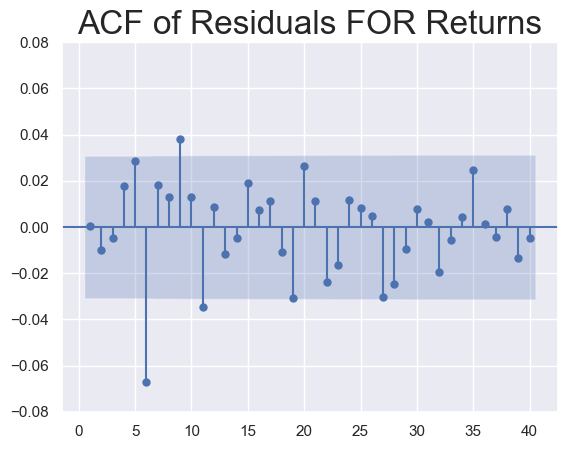

In [69]:
## Ploting ACF of Residual Returns
sgt.plot_acf(df.res_ret,lags=40,zero=False)
plt.ylim(-0.08,0.08)
plt.title("ACF of Residuals FOR Returns",size=24)

Text(0.5, 1.0, 'Residual of Returns')

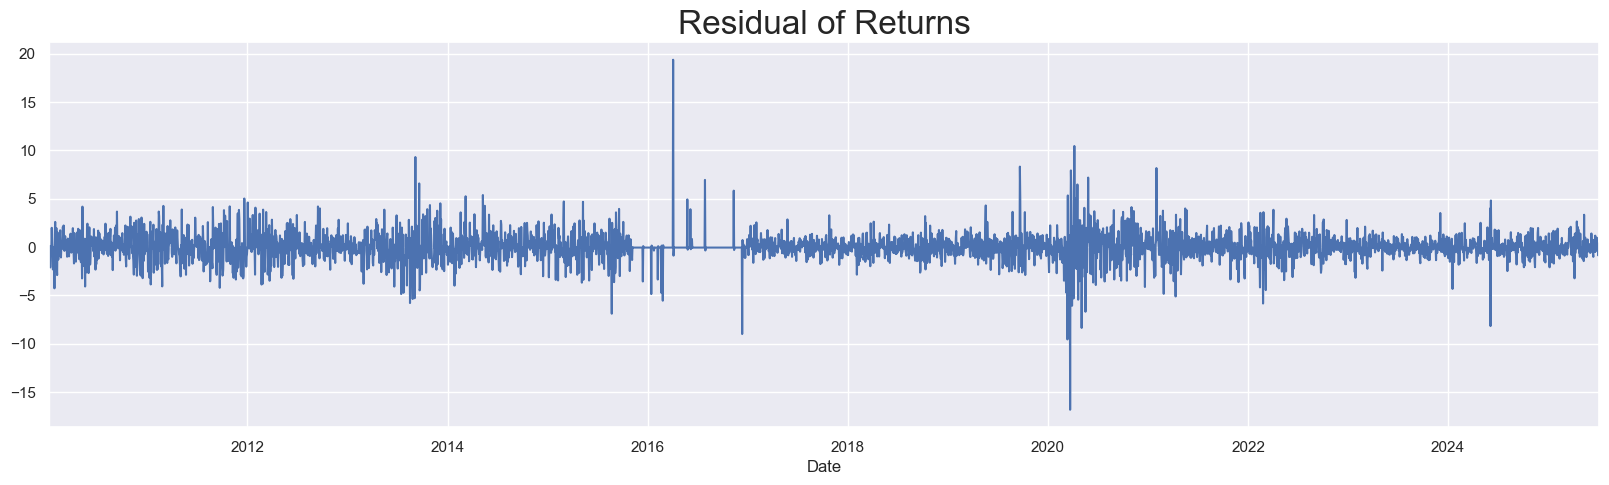

In [71]:
## Ploting Residual Returns
df.res_ret[1:].plot(figsize=(20,5))
plt.title("Residual of Returns",size=24)